In [ ]:
# Kütüphane Yükleme
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Stil ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

df = pd.read_csv("/content/chess_data.csv")

# Başlamamış satranç maçlarını status sütunundan çıkarıyoruz
df = df[df['status'] != 'noStart']

# Kullanacağımız sütunlardaki NaN değerleri atıyoruz
df = df.dropna(subset=['white_rating', 'black_rating', 'winner', 'pgn', 'time_control'])

# Kullanılacak veri sayısını belirleme
df = df.sample(n=25000, random_state=42)

print(df.head())

         game_id       white  white_rating                 black  \
90807   KOnfDsMd  flamaster7        2524.0  kingscrusher-youtube   
28824   6IShcMsD     oleg946        2486.0          wild_of_luck   
22581   90bEEXIe     oleg946        2708.0      daichangrenshab1   
18759   oEHwr4L9        gsvc        2265.0          bruce_sydney   
127451  yx2giWeT    degreemo        1910.0  kingscrusher-youtube   

        black_rating winner     status  time_control  incriment  \
90807         2562.0  white     resign          60.0        0.0   
28824         2518.0  black       mate         180.0        0.0   
22581         2756.0  black       mate          60.0        0.0   
18759         2051.0  white  outoftime         180.0        0.0   
127451        2531.0  white  outoftime          60.0        0.0   

                                                      pgn  
90807   e4 Nc6 Nf3 e5 d4 exd4 Bc4 Nf6 O-O d6 Nxd4 Be7 ...  
28824   e4 c5 d4 cxd4 Qxd4 Nc6 Qe3 Nf6 c4 e5 Nc3 Qa5 B...  
22581   

In [ ]:
# pgn sütunundan sadece ilk hamleyi çekiyoruz
def simplify_opening(pgn):
    moves = pgn.strip().split()
    return moves[0] if len(moves) > 0 else "Unknown"

df["Opening"] = df["pgn"].apply(simplify_opening)

print(df[["Opening"]].head())

# 2. Rating Farkı (En önemli feature)
# Beyazın siyahtan ne kadar güçlü olduğunu gösterir. Pozitifse beyaz güçlü.
df["rating_diff"] = df["white_rating"] - df["black_rating"]
print(df[["rating_diff"]])

       Opening
90807       e4
28824       e4
22581       e4
18759       e4
127451      e4
        rating_diff
90807         -38.0
28824         -32.0
22581         -48.0
18759         214.0
127451       -621.0
...             ...
542          -320.0
49358         -50.0
5281          236.0
100322        414.0
138199       -182.0

[25000 rows x 1 columns]


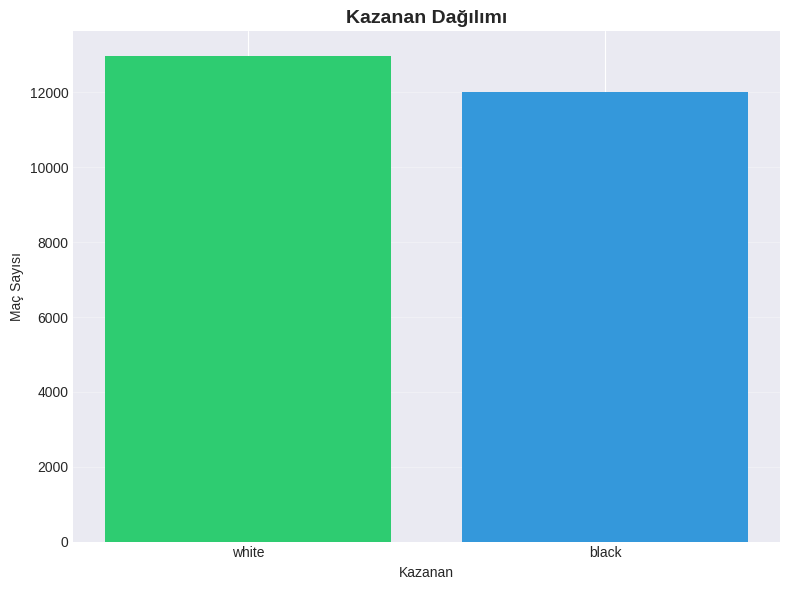

In [ ]:
# ========== VERİ GÖRSELLEŞTİRME ==========
# 1. Kazanan Dağılımı
plt.figure(figsize=(8, 6))
winner_counts = df['winner'].value_counts()
plt.bar(winner_counts.index, winner_counts.values, color=['#2ecc71', '#3498db', '#e74c3c'])
plt.title('Kazanan Dağılımı', fontsize=14, fontweight='bold')
plt.xlabel('Kazanan')
plt.ylabel('Maç Sayısı')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

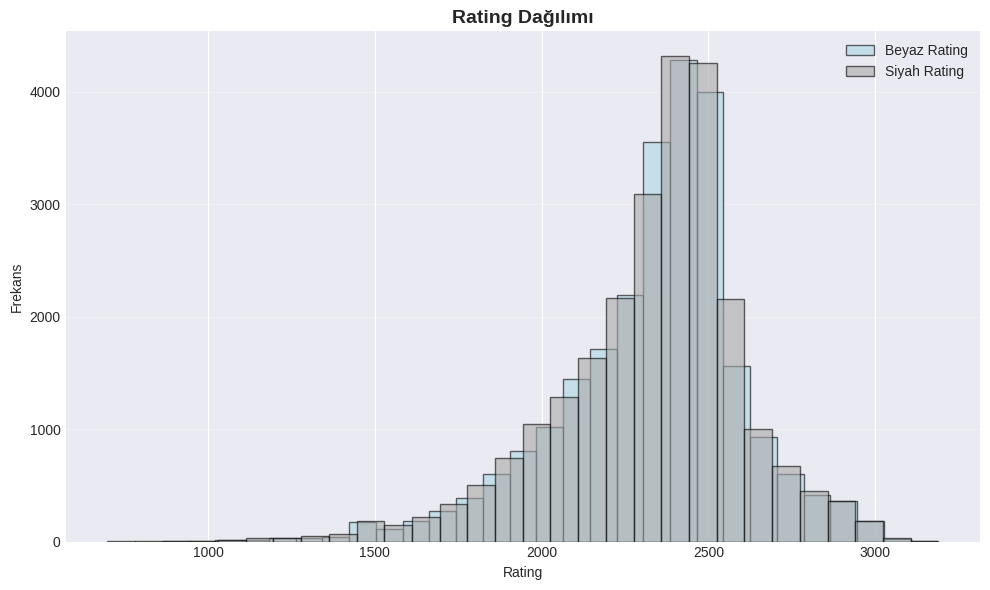

In [ ]:
# 2. Rating Dağılımı
plt.figure(figsize=(10, 6))
plt.hist(df['white_rating'], bins=30, alpha=0.6, label='Beyaz Rating', color='lightblue', edgecolor='black')
plt.hist(df['black_rating'], bins=30, alpha=0.6, label='Siyah Rating', color='darkgray', edgecolor='black')
plt.title('Rating Dağılımı', fontsize=14, fontweight='bold')
plt.xlabel('Rating')
plt.ylabel('Frekans')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

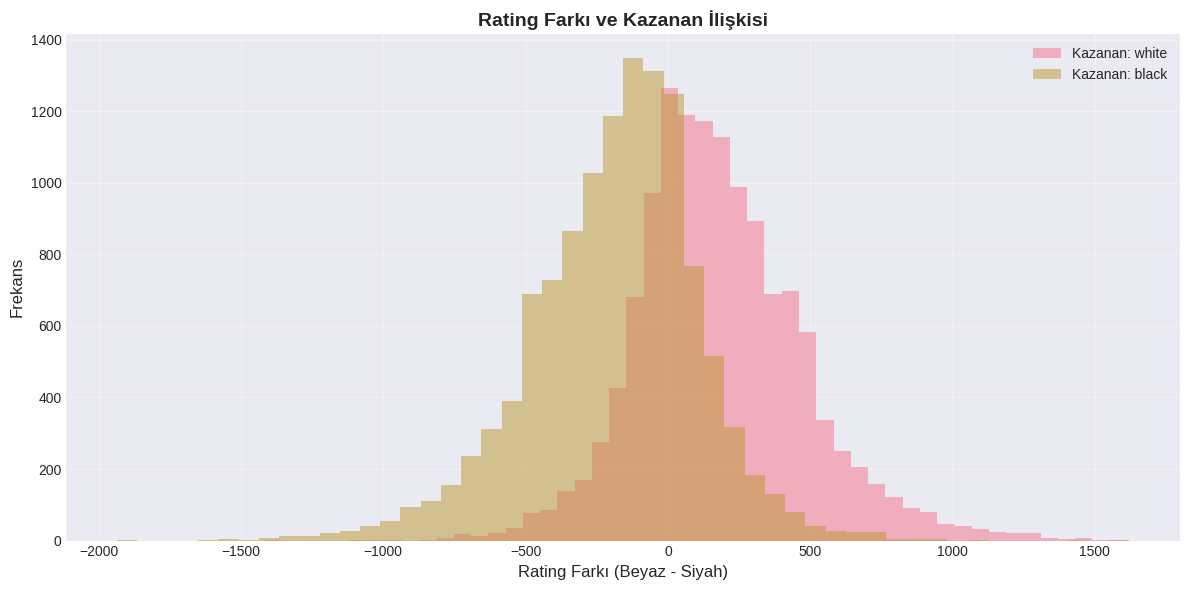

In [ ]:
# 3. Rating Farkı vs Kazanan
plt.figure(figsize=(12, 6))
for winner in df['winner'].unique():
    subset = df[df['winner'] == winner]
    plt.hist(subset['rating_diff'], bins=50, alpha=0.5, label=f'Kazanan: {winner}')
plt.xlabel('Rating Farkı (Beyaz - Siyah)', fontsize=12)
plt.ylabel('Frekans', fontsize=12)
plt.title('Rating Farkı ve Kazanan İlişkisi', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


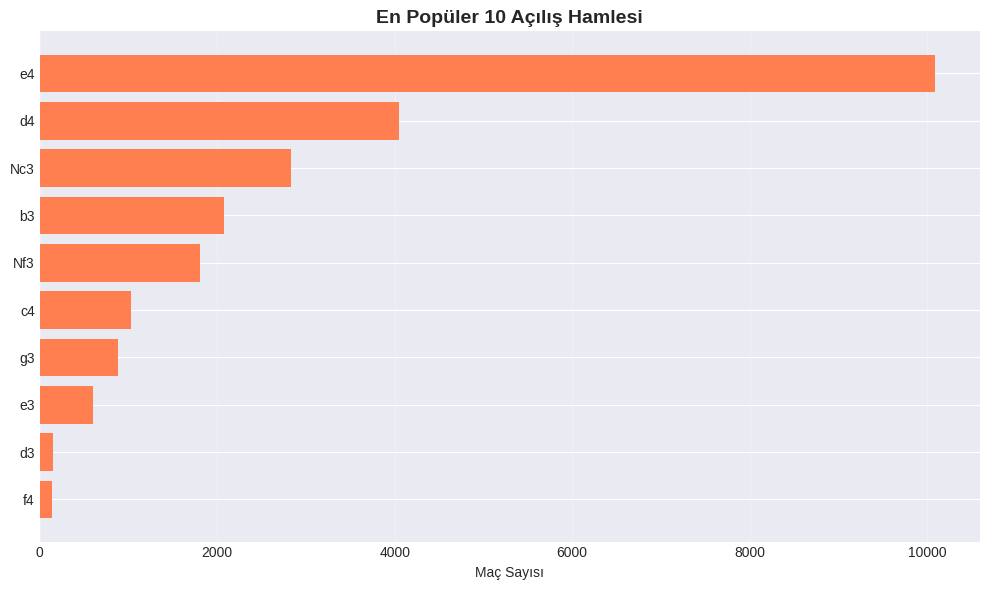

In [ ]:
# 4. En Popüler Açılışlar
plt.figure(figsize=(10, 6))
opening_counts = df['Opening'].value_counts().head(10)
plt.barh(opening_counts.index, opening_counts.values, color='coral')
plt.title('En Popüler 10 Açılış Hamlesi', fontsize=14, fontweight='bold')
plt.xlabel('Maç Sayısı')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ========== MODEL EĞİTİMİ ==========

features = ["white_rating", "black_rating","rating_diff", "time_control", "Opening"]
target = "winner"

X = df[features].copy()
y = df[target].copy()

X = X.dropna()
y = y.loc[X.index]

# Label Encoding
le_time = LabelEncoder()
X["time_control"] = le_time.fit_transform(X["time_control"].astype(str))

le_opening = LabelEncoder()
X["Opening"] = le_opening.fit_transform(X["Opening"].astype(str))

le_y = LabelEncoder()
y = le_y.fit_transform(y)

print("Encoded classes:", le_y.classes_)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Encoded classes: ['black' 'white']


In [ ]:
# --- SCALING (Logistic Regression için zorunlu) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Denetimli Öğrenme Modelleri
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True) # ROC Curve için probability=True lazım
}
results={}
best_model = None
best_model_name = None
best_acc = 0
# Denetimli öğrenme modellerinin her biri için acc değeri hesaplanacak ve en iyi başarımı sağlayan ile görselleştirme yapacağız.

for name, model in models.items():
    # Eğitim
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"{name} Başarısı: %{acc*100:.2f}")

    # En iyi modeli seç
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_model_name = name

Logistic Regression Başarısı: %74.22
Random Forest Başarısı: %70.94
Decision Tree Başarısı: %65.88
KNN Başarısı: %71.32
Naive Bayes Başarısı: %74.34
SVM Başarısı: %74.42


In [ ]:
# ---- BURADAN SONRA SADECE EN İYİ MODEL KULLANILACAK ----

# EN İYİ MODELİN TAHMİNLERİ
y_pred = best_model.predict(X_test_scaled)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le_y.classes_))


Accuracy: 0.7442

Classification Report:
               precision    recall  f1-score   support

       black       0.74      0.70      0.72      2373
       white       0.74      0.78      0.76      2627

    accuracy                           0.74      5000
   macro avg       0.74      0.74      0.74      5000
weighted avg       0.74      0.74      0.74      5000



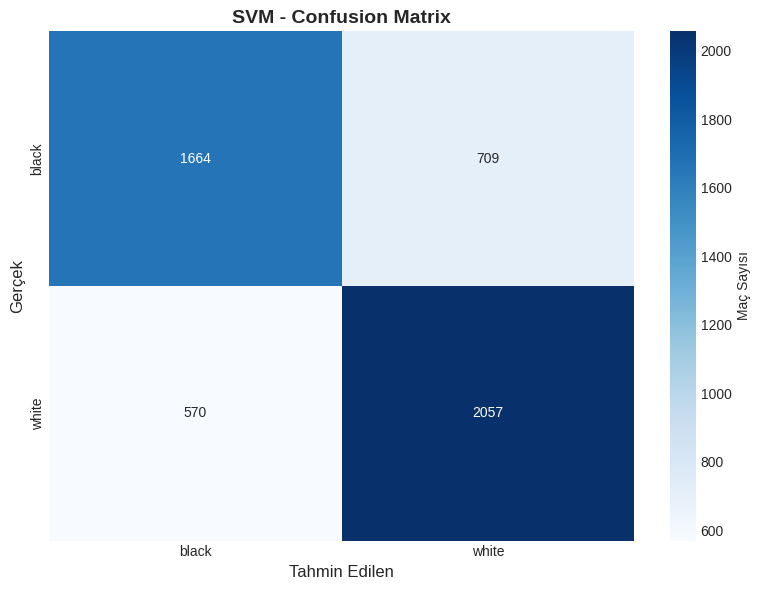

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_y.classes_,
            yticklabels=le_y.classes_,
            cbar_kws={'label': 'Maç Sayısı'})
plt.title(f'{best_model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Tahmin Edilen', fontsize=12)
plt.ylabel('Gerçek', fontsize=12)
plt.tight_layout()
plt.show()

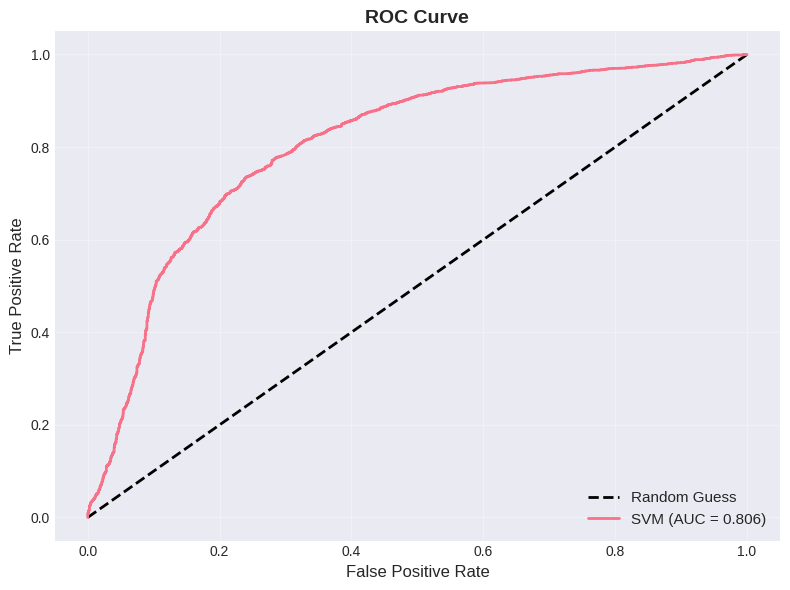


AUC Score: 0.8059

Tüm analizler tamamlandı!


In [ ]:
# ROC Curve (binary)
if len(le_y.classes_) == 2:
    y_scores = best_model.predict_proba(X_test_scaled)
    fpr, tpr, thresholds = roc_curve(y_test, y_scores[:, 1])
    auc = roc_auc_score(y_test, y_scores[:, 1])

    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', linewidth=2)
    plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {auc:.3f})', linewidth=2)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\nAUC Score: {auc:.4f}")

else:
    print("\nROC yalnızca 2 sınıflı veride hesaplanır.")

    report_dict = classification_report(y_test, y_pred, target_names=le_y.classes_, output_dict=True)

    classes = le_y.classes_
    f1_scores = [report_dict[c]['f1-score'] for c in classes]

    plt.figure(figsize=(10, 6))
    plt.bar(classes, f1_scores)
    plt.xlabel('Sınıf', fontsize=12)
    plt.ylabel('F1-Score', fontsize=12)
    plt.title('Sınıf Bazlı F1-Score', fontsize=14, fontweight='bold')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\nTüm analizler tamamlandı!")

In [20]:
# =====================================
# MODELİN NASIL TAHMİN YAPTIĞINI GÖZLEMLEME
# =====================================

test_match = {
    "white_rating": 2743.0,
    "black_rating": 2909.0,
    "rating_diff": 2743.0 - 2909.0,
    "time_control": "180.0",
    "Opening": "e4"
}

# Encode etmek için modelde kullanılan encoderları kullanıyoruz
test_df = pd.DataFrame([test_match])

test_df["time_control"] = le_time.transform(test_df["time_control"])
test_df["Opening"] = le_opening.transform(test_df["Opening"])

# Scale etme
test_scaled = scaler.transform(test_df)

print("\n=== EN İYİ MODEL TAHMİNİ ===")
print(f"En iyi model: {best_model_name}")
print("Beklenen sonuç: black\n")

pred_class = best_model.predict(test_scaled)[0]
pred_label = le_y.inverse_transform([pred_class])[0]

print(f"Model Tahmini: {pred_label}")


=== EN İYİ MODEL TAHMİNİ ===
En iyi model: SVM
Beklenen sonuç: black

Model Tahmini: black
